In [33]:
import numpy as np

def onedim_8sites_IsingModel_PBC(qc,n_qubits,dt):
    
    odd=[0,2]
    even=[1]
    for i in range(n_qubits):
        qc.rz(-2*ht*dt,i) #qc.rz(-2 * theta, i)  # Implements e^{i θ Z} to the qubit i
    qc.barrier()
    for i in odd:
        qc.cx(i,i+1)
    for i in odd:
        qc.rx(-2*J*dt,i)
    for i in odd:
        qc.cx(i,i+1)
    qc.barrier()
    for i in even:
        qc.cx(i,i+1)
    for i in even:
        qc.rx(-2*J*dt,i)
    for i in even:
        qc.cx(i,i+1)
    qc.barrier()      
    qc.cx(0,n_qubits-1)
    qc.rx(-2*J*dt,0)
    qc.cx(0,n_qubits-1)
    qc.barrier()      

In [74]:
"""
NumPy Simulation Data:
"""
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

from qiskit_aer.noise import pauli_error, NoiseModel

pI1 = 1 - 3*0.0005 # probability of no error
p1 = [pI1, 0.0005, 0.0005, 0.0005]   #Optimistic error rates for current trapped ions for 1-qubit error
pI2 = 1 - 3*0.004 
p2 = [pI2, 0.004, 0.004, 0.004]   #Optimistic error rates for near-term superconducting qubits for 2-qubit error
p_meas = 0.05
# QuantumError objects
error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
error_table2 = pauli_error([("X", p1[1]), ("Y", p1[2]),("Z", p1[3]),("I", p1[0])])
error_gate2 = pauli_error([("X", p2[1]), ("Y", p2[2]),("Z", p2[3]),("I", p2[0])])
error_table3 = error_gate2.tensor(error_gate2)
 
# Add errors to noise model
noise = NoiseModel()

noise.add_all_qubit_quantum_error(error_meas, "measure")
noise.add_all_qubit_quantum_error(error_table2, ["u1", "u2", "u3","x", "sx", "rz"])
noise.add_all_qubit_quantum_error(error_table3, ["cx"])
 
print(noise)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']
  Instructions with noise: ['x', 'measure', 'u3', 'cx', 'u2', 'sx', 'u1', 'rz']
  All-qubits errors: ['measure', 'u1', 'u2', 'u3', 'x', 'sx', 'rz', 'cx']


In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator

sim = AerSimulator(noise_model=noise, shots = 10000)


def prob_qubit_one(qc, target_qubit, shots):

    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    count_one = 0
    for bitstring, freq in counts.items():
        if bitstring[::-1][target_qubit] == "1":
            count_one += freq

    prob_target = count_one / sum(counts.values())
    return prob_target


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister 
from qiskit.quantum_info import Statevector
J=0.02
ht=1
dt=5
time_steps=16
n_qubits=4
qr=QuantumRegister(n_qubits)
qc=QuantumCircuit(qr)
probs = []
target_qubit=2
shots=10000

initial_state = Statevector.from_label("0001") 
sinit=qc.initialize(initial_state)
for t in range(time_steps):
    # Copy current circuit and add measurements
    qc_meas = qc.copy()
    qc_meas.measure_all()

    #  Run in the simulator
    p = prob_qubit_one(qc_meas, target_qubit, shots)
    probs.append(p)
    
    # Evolve the original circuit (without measurements) for the next step.
    onedim_8sites_IsingModel_PBC(qc, n_qubits, dt)


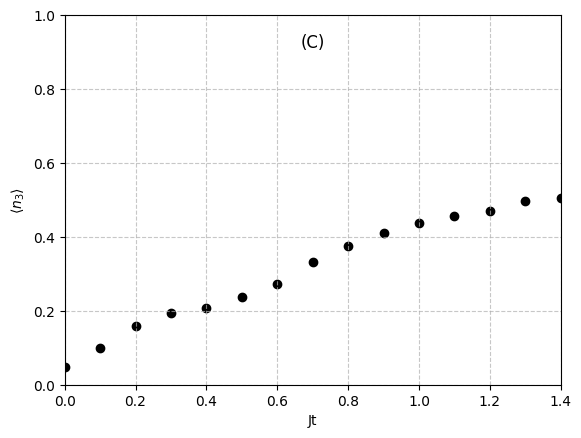

In [ ]:
import matplotlib.pyplot as plt

x_vals=np.arange(time_steps)*J*dt
plt.scatter(x_vals, probs, color='black')
plt.ylim(0,1)
plt.xlabel("Jt")
plt.ylabel(fr"$\langle n_{{{target_qubit+1}}} \rangle$")
plt.text(
    x=0.5, y=0.95, s="(C)", 
    ha='center', va='top', transform=plt.gca().transAxes, fontsize=12
)
plt.xlim(0,1.4)
#plt.title(f"Occupation value for site {target_qubit+1}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()